# Exploratory Data Analysis - Fake News Detection

This notebook performs comprehensive EDA on the fake news dataset to understand:
- Data distribution and class balance
- Text characteristics (length, vocabulary, etc.)
- Feature patterns that might distinguish fake from real news
- Potential data quality issues

In [1]:
# Import required libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Import project modules
from src.config import PROCESSED_DATA_DIR, FIGURES_DIR
from src.data_io import DataLoader

print("Libraries loaded successfully!")

ModuleNotFoundError: No module named 'config'

## 1. Load Data

In [2]:
# Load processed data
loader = DataLoader()

try:
    train_df, val_df, test_df = loader.load_processed_data()
    print("✓ Loaded processed data")
except FileNotFoundError:
    print("⚠ No processed data found. Loading raw data...")
    df = loader.load_data()
    train_df, val_df, test_df = loader.create_splits(df)
    print("✓ Created data splits")

# Combine for overall statistics
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\nDataset size:")
print(f"  Total: {len(all_df):,} samples")
print(f"  Train: {len(train_df):,} samples")
print(f"  Val: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")

NameError: name 'DataLoader' is not defined

## 2. Class Distribution

NameError: name 'all_df' is not defined

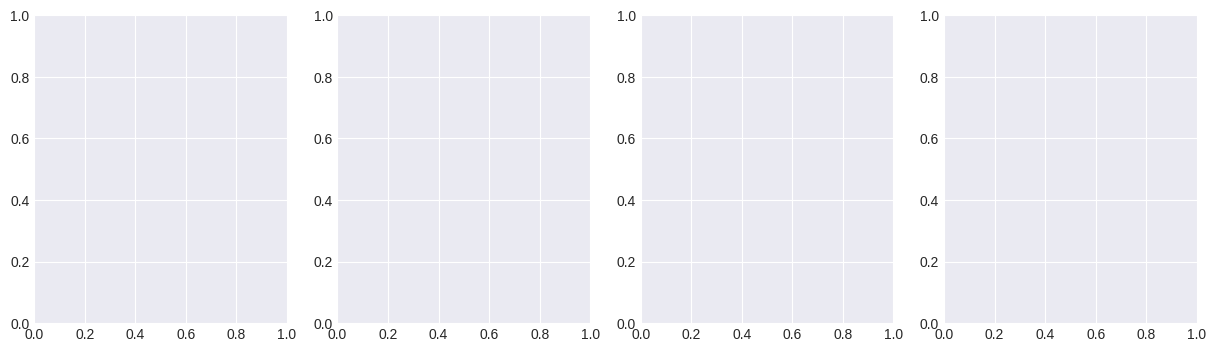

In [3]:
# Analyze class distribution
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, (name, df) in zip(axes, [('Overall', all_df), ('Train', train_df), 
                                  ('Val', val_df), ('Test', test_df)]):
    class_counts = df['label'].value_counts()
    
    # Create pie chart
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(class_counts.values, labels=['Real', 'Fake'], colors=colors,
           autopct='%1.1f%%', startangle=90)
    ax.set_title(f'{name} Set\n({len(df):,} samples)')

plt.suptitle('Class Distribution Across Splits', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

# Print imbalance ratio
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    fake_ratio = (df['label'] == 1).mean()
    print(f"{name} set - Fake news ratio: {fake_ratio:.2%}")

## 3. Text Length Analysis

In [4]:
# Add text statistics if not present
if 'text_length' not in train_df.columns:
    for df in [train_df, val_df, test_df]:
        df['text_length'] = df['text'].str.len()
        df['word_count'] = df['text'].str.split().str.len()
        df['sentence_count'] = df['text'].str.count('[.!?]') + 1

# Plot text length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character length distribution
ax = axes[0, 0]
for label, name in [(0, 'Real'), (1, 'Fake')]:
    data = train_df[train_df['label'] == label]['text_length']
    ax.hist(data, bins=50, alpha=0.6, label=name, density=True)
ax.set_xlabel('Character Count')
ax.set_ylabel('Density')
ax.set_title('Character Length Distribution')
ax.legend()
ax.set_xlim(0, np.percentile(train_df['text_length'], 95))

# Word count distribution
ax = axes[0, 1]
for label, name in [(0, 'Real'), (1, 'Fake')]:
    data = train_df[train_df['label'] == label]['word_count']
    ax.hist(data, bins=50, alpha=0.6, label=name, density=True)
ax.set_xlabel('Word Count')
ax.set_ylabel('Density')
ax.set_title('Word Count Distribution')
ax.legend()
ax.set_xlim(0, np.percentile(train_df['word_count'], 95))

# Box plot comparison
ax = axes[1, 0]
train_df.boxplot(column='word_count', by='label', ax=ax)
ax.set_xlabel('Label (0=Real, 1=Fake)')
ax.set_ylabel('Word Count')
ax.set_title('Word Count by Label')
plt.sca(ax)
plt.xticks([1, 2], ['Real', 'Fake'])

# Statistical summary
ax = axes[1, 1]
ax.axis('off')
summary_text = "Text Length Statistics:\n\n"
for label, name in [(0, 'Real'), (1, 'Fake')]:
    subset = train_df[train_df['label'] == label]
    summary_text += f"{name} News:\n"
    summary_text += f"  Avg chars: {subset['text_length'].mean():.0f}\n"
    summary_text += f"  Avg words: {subset['word_count'].mean():.0f}\n"
    summary_text += f"  Avg sentences: {subset['sentence_count'].mean():.1f}\n"
    summary_text += f"  Median words: {subset['word_count'].median():.0f}\n\n"

ax.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
        fontfamily='monospace')

plt.suptitle('Text Length Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'text_length_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

NameError: name 'train_df' is not defined

## 4. Vocabulary Analysis

In [5]:
# Get most common words for each class
def get_top_words(df, label, n=20):
    """Get top n words for a given label"""
    texts = ' '.join(df[df['label'] == label]['text'].dropna().values)
    
    # Simple tokenization and counting
    words = texts.lower().split()
    # Remove very short words and numbers
    words = [w for w in words if len(w) > 2 and not w.isdigit()]
    
    return Counter(words).most_common(n)

# Get top words
real_top_words = get_top_words(train_df, 0, 20)
fake_top_words = get_top_words(train_df, 1, 20)

# Plot top words
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real news top words
ax = axes[0]
words, counts = zip(*real_top_words[:15])
ax.barh(range(len(words)), counts, color='#2ecc71')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.set_xlabel('Frequency')
ax.set_title('Top 15 Words in Real News')
ax.invert_yaxis()

# Fake news top words
ax = axes[1]
words, counts = zip(*fake_top_words[:15])
ax.barh(range(len(words)), counts, color='#e74c3c')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.set_xlabel('Frequency')
ax.set_title('Top 15 Words in Fake News')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'top_words.png', dpi=100, bbox_inches='tight')
plt.show()

NameError: name 'train_df' is not defined

## 5. Word Clouds

NameError: name 'train_df' is not defined

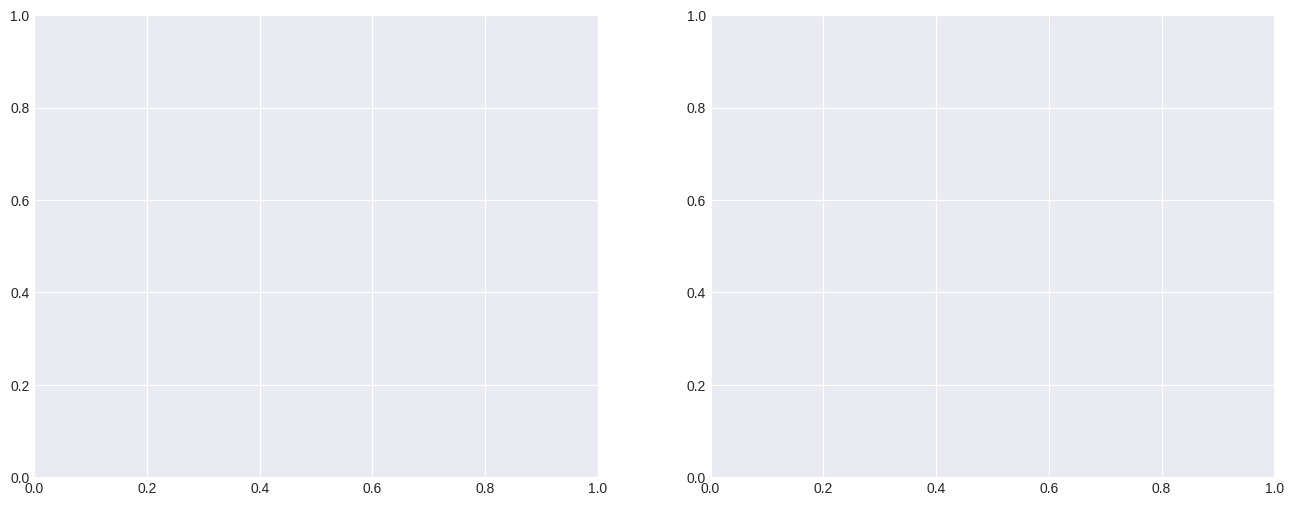

In [6]:
# Generate word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Real news word cloud
real_text = ' '.join(train_df[train_df['label'] == 0]['text'].dropna().values)
wordcloud_real = WordCloud(width=800, height=400, 
                           background_color='white',
                           colormap='Greens',
                           max_words=100).generate(real_text)

axes[0].imshow(wordcloud_real, interpolation='bilinear')
axes[0].set_title('Real News Word Cloud', fontsize=16)
axes[0].axis('off')

# Fake news word cloud
fake_text = ' '.join(train_df[train_df['label'] == 1]['text'].dropna().values)
wordcloud_fake = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Reds',
                           max_words=100).generate(fake_text)

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title('Fake News Word Cloud', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'word_clouds.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. N-gram Analysis

In [7]:
# Analyze bigrams and trigrams
def get_top_ngrams(df, label, n=2, top_k=15):
    """Get top k n-grams for a given label"""
    texts = df[df['label'] == label]['text'].dropna().values
    
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=top_k,
                                 stop_words='english')
    ngrams = vectorizer.fit_transform(texts)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_names = vectorizer.get_feature_names_out()
    
    return sorted(zip(ngram_names, ngram_counts), key=lambda x: x[1], reverse=True)

# Get bigrams
real_bigrams = get_top_ngrams(train_df, 0, n=2, top_k=15)
fake_bigrams = get_top_ngrams(train_df, 1, n=2, top_k=15)

# Plot bigrams
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real news bigrams
ax = axes[0]
if real_bigrams:
    bigrams, counts = zip(*real_bigrams)
    ax.barh(range(len(bigrams)), counts, color='#3498db')
    ax.set_yticks(range(len(bigrams)))
    ax.set_yticklabels(bigrams)
    ax.set_xlabel('Frequency')
    ax.set_title('Top Bigrams in Real News')
    ax.invert_yaxis()

# Fake news bigrams
ax = axes[1]
if fake_bigrams:
    bigrams, counts = zip(*fake_bigrams)
    ax.barh(range(len(bigrams)), counts, color='#e67e22')
    ax.set_yticks(range(len(bigrams)))
    ax.set_yticklabels(bigrams)
    ax.set_xlabel('Frequency')
    ax.set_title('Top Bigrams in Fake News')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'bigrams.png', dpi=100, bbox_inches='tight')
plt.show()

NameError: name 'train_df' is not defined

## 7. TF-IDF Analysis

In [ ]:
# Compute TF-IDF for most distinctive words
def get_distinctive_words(df, n_features=20):
    """Get most distinctive words for each class using TF-IDF"""
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english',
                            ngram_range=(1, 2))
    
    # Fit on all data
    X = tfidf.fit_transform(df['text'].dropna())
    feature_names = tfidf.get_feature_names_out()
    
    # Get mean TF-IDF scores for each class
    real_scores = X[df['label'] == 0].mean(axis=0).A1
    fake_scores = X[df['label'] == 1].mean(axis=0).A1
    
    # Get difference (words more common in fake vs real)
    diff_scores = fake_scores - real_scores
    
    # Get top words for each class
    real_indices = diff_scores.argsort()[:n_features]
    fake_indices = diff_scores.argsort()[-n_features:][::-1]
    
    real_words = [(feature_names[i], real_scores[i]) for i in real_indices]
    fake_words = [(feature_names[i], fake_scores[i]) for i in fake_indices]
    
    return real_words, fake_words

# Get distinctive words
real_distinctive, fake_distinctive = get_distinctive_words(train_df)

# Display distinctive words
print("Most distinctive words/phrases:\n")
print("REAL NEWS:")
for word, score in real_distinctive[:10]:
    print(f"  {word:30s} (score: {score:.4f})")

print("\nFAKE NEWS:")
for word, score in fake_distinctive[:10]:
    print(f"  {word:30s} (score: {score:.4f})")

## 8. Linguistic Features Analysis

In [ ]:
# Add linguistic features if not present
import string

for df in [train_df, val_df, test_df]:
    if 'punctuation_density' not in df.columns:
        # Punctuation density
        df['punctuation_density'] = df['text'].apply(
            lambda x: sum(c in string.punctuation for c in str(x)) / max(len(str(x)), 1)
        )
        
        # Capital letters ratio
        df['capital_ratio'] = df['text'].apply(
            lambda x: sum(c.isupper() for c in str(x)) / max(len(str(x)), 1)
        )
        
        # Exclamation and question marks
        df['exclamation_count'] = df['text'].str.count('!')
        df['question_count'] = df['text'].str.count('\?')

# Plot linguistic features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ['punctuation_density', 'capital_ratio', 'exclamation_count', 'question_count']
titles = ['Punctuation Density', 'Capital Letters Ratio', 
          'Exclamation Marks Count', 'Question Marks Count']

for ax, feature, title in zip(axes.flat, features, titles):
    for label, name, color in [(0, 'Real', '#2ecc71'), (1, 'Fake', '#e74c3c')]:
        data = train_df[train_df['label'] == label][feature]
        ax.hist(data, bins=30, alpha=0.6, label=name, density=True, color=color)
    
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'Distribution of {title}')
    
    # Add mean lines
    for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
        mean_val = train_df[train_df['label'] == label][feature].mean()
        ax.axvline(mean_val, color=color, linestyle='--', alpha=0.8)

plt.suptitle('Linguistic Features Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'linguistic_features.png', dpi=100, bbox_inches='tight')
plt.show()

# Statistical comparison
print("\nStatistical comparison of linguistic features:\n")
for feature in features:
    real_mean = train_df[train_df['label'] == 0][feature].mean()
    fake_mean = train_df[train_df['label'] == 1][feature].mean()
    diff_pct = (fake_mean - real_mean) / real_mean * 100
    
    print(f"{feature:20s}: Real={real_mean:.4f}, Fake={fake_mean:.4f}, "
          f"Diff={diff_pct:+.1f}%")

## 9. Missing Data and Quality Checks

In [ ]:
# Check for missing values
print("Missing values analysis:\n")
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    missing = df.isnull().sum()
    missing_pct = missing / len(df) * 100
    
    print(f"{name} set:")
    for col in missing[missing > 0].index:
        print(f"  {col}: {missing[col]} ({missing_pct[col]:.1f}%)")
    
    if missing.sum() == 0:
        print("  No missing values")
    print()

# Check for duplicates
print("\nDuplicate analysis:")
duplicates = train_df['text'].duplicated().sum()
print(f"Duplicate texts in training set: {duplicates}")

# Check for very short texts
print("\nShort text analysis:")
for threshold in [10, 20, 50]:
    short_texts = (train_df['word_count'] < threshold).sum()
    print(f"Texts with < {threshold} words: {short_texts} ({short_texts/len(train_df)*100:.1f}%)")

# Check for potential data leakage
print("\nData leakage check:")
train_texts = set(train_df['text'].values)
val_texts = set(val_df['text'].values)
test_texts = set(test_df['text'].values)

train_val_overlap = len(train_texts.intersection(val_texts))
train_test_overlap = len(train_texts.intersection(test_texts))
val_test_overlap = len(val_texts.intersection(test_texts))

print(f"Train-Val overlap: {train_val_overlap} texts")
print(f"Train-Test overlap: {train_test_overlap} texts")
print(f"Val-Test overlap: {val_test_overlap} texts")

## 10. Feature Correlation

In [ ]:
# Compute correlation between features and target
numeric_features = ['text_length', 'word_count', 'sentence_count',
                   'punctuation_density', 'capital_ratio',
                   'exclamation_count', 'question_count']

# Compute correlations
correlations = train_df[numeric_features + ['label']].corr()['label'].sort_values(ascending=False)

# Plot correlations
plt.figure(figsize=(10, 6))
correlations[:-1].plot(kind='barh', color=['#e74c3c' if x > 0 else '#3498db' 
                                           for x in correlations[:-1]])
plt.xlabel('Correlation with Fake News Label')
plt.title('Feature Correlations with Target')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_correlations.png', dpi=100, bbox_inches='tight')
plt.show()

print("Feature correlations with fake news label:")
for feature, corr in correlations[:-1].items():
    print(f"  {feature:20s}: {corr:+.3f}")

## 11. Summary and Insights

In [ ]:
print("=" * 60)
print("EDA SUMMARY AND KEY INSIGHTS")
print("=" * 60)

# Class balance
fake_ratio = (train_df['label'] == 1).mean()
print(f"\n1. CLASS BALANCE:")
print(f"   - Fake news ratio: {fake_ratio:.1%}")
if fake_ratio > 0.4 and fake_ratio < 0.6:
    print("   - Classes are relatively balanced ✓")
else:
    print("   - Classes are imbalanced - consider using class weights ⚠")

# Text characteristics
print(f"\n2. TEXT CHARACTERISTICS:")
print(f"   - Average text length: {train_df['word_count'].mean():.0f} words")
print(f"   - Median text length: {train_df['word_count'].median():.0f} words")
print(f"   - Text length range: {train_df['word_count'].min()}-{train_df['word_count'].max()} words")

# Feature importance hints
print(f"\n3. POTENTIAL DISCRIMINATIVE FEATURES:")
top_correlations = correlations[:-1].abs().sort_values(ascending=False).head(3)
for feature, corr in top_correlations.items():
    print(f"   - {feature}: {abs(corr):.3f} correlation")

# Data quality
print(f"\n4. DATA QUALITY:")
print(f"   - Duplicate texts: {duplicates}")
print(f"   - Missing values: {train_df.isnull().sum().sum()}")
print(f"   - Very short texts (<20 words): {(train_df['word_count'] < 20).sum()}")

# Recommendations
print(f"\n5. RECOMMENDATIONS:")
print("   ✓ Text is suitable for both traditional ML and transformer models")
if fake_ratio < 0.4 or fake_ratio > 0.6:
    print("   ✓ Use class weights or resampling for imbalanced data")
print("   ✓ Consider using TF-IDF with bigrams for baseline")
print("   ✓ Linguistic features show promise for classification")
print("   ✓ Remove duplicates before training")

print("\n" + "=" * 60)
print("EDA Complete! Ready to proceed with baseline models.")
print("=" * 60)